# UNDERSTANDING


[Info] Script directory : C:\Users\manht\MACHINE LEARNING PROJECT\CUP-DATA
[Info] Dataset directory: C:\Users\manht\MACHINE LEARNING PROJECT\CUP-DATA\dataset

=== STEP 1: Load TRAIN file ===
Train path     : C:\Users\manht\MACHINE LEARNING PROJECT\CUP-DATA\dataset\ML-CUP25-TR.csv
Train samples  : 500

=== STEP 2: Save CLEAN TRAIN files ===
Saved: cup25_train_clean.csv

=== STEP 3: Compute & Plot Correlation Matrix ===

[Display] Showing Correlation Heatmap:


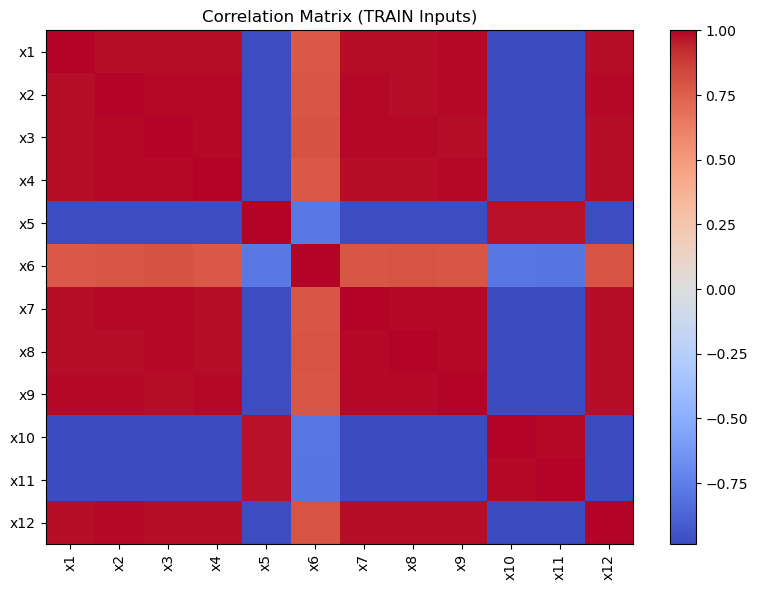

Saved CSV    : cup25_train_input_correlation.csv
Saved Image  : cup25_train_input_correlation_heatmap.png
Saved Top 20 : cup25_top20_correlated_pairs.csv

=== STEP 4: Load TEST file ===
Test path      : C:\Users\manht\MACHINE LEARNING PROJECT\CUP-DATA\dataset\ML-CUP25-TS.csv

=== STEP 5: Save CLEAN TEST files ===
Saved: cup25_test_clean.csv

DONE ✅


In [13]:
import os
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 0: Path & Utility Functions

def resolve_path(user_input: str, dataset_dir: Path, exts=("", ".csv", ".txt")) -> Path:
    """
    Resolve a file path robustly.
    1. If absolute/relative with separators, use directly.
    2. Search in 'dataset_dir'.
    3. Try appending extensions.
    """
    p = Path(user_input)

    if p.is_absolute() or ("/" in user_input) or ("\\" in user_input):
        candidates = [p] + [Path(str(p) + ext) for ext in exts if ext]
    else:
        candidates = [dataset_dir / p] + [(dataset_dir / Path(str(p) + ext)) for ext in exts if ext]

    for c in candidates:
        if c.exists() and c.is_file():
            return c

    msg = "Tried these candidates:\n" + "\n".join(str(c) for c in candidates)
    raise FileNotFoundError(f"Could not find file for input '{user_input}'.\n{msg}")


def load_cup_csv(path: Path, n_inputs: int, n_targets: int):
    """
    Load ML-CUP CSV (ignores '#' comments).
    """
    df = pd.read_csv(path, comment="#", header=None)
    df = df.dropna(how="all")
    df = df.apply(pd.to_numeric, errors="raise")

    n_cols = df.shape[1]
    train_expected = 1 + n_inputs + n_targets
    test_expected = 1 + n_inputs

    # Train format
    if n_cols == train_expected:
        ID = df.iloc[:, 0].to_numpy()
        X = df.iloc[:, 1:1 + n_inputs].to_numpy()
        y = df.iloc[:, 1 + n_inputs:1 + n_inputs + n_targets].to_numpy()
        return ID, X, y

    # Test format
    if n_cols == test_expected:
        ID = df.iloc[:, 0].to_numpy()
        X = df.iloc[:, 1:1 + n_inputs].to_numpy()
        return ID, X, None

    raise ValueError(f"Unexpected columns: {n_cols}. Expected {train_expected} (train) or {test_expected} (test).")

# Step 1 & 2: Saving Clean Data

def save_clean_train(X: np.ndarray, y: np.ndarray, out_prefix: str):
    n_inputs = X.shape[1]
    n_targets = y.shape[1]
    cols = [f"x{i}" for i in range(1, n_inputs + 1)] + [f"y{i}" for i in range(1, n_targets + 1)]
    df_clean = pd.DataFrame(np.hstack([X, y]), columns=cols)

    out_path = f"{out_prefix}_train_clean.csv"
    df_clean.to_csv(out_path, index=False)
    return out_path


def save_clean_test(X: np.ndarray, out_prefix: str):
    n_inputs = X.shape[1]
    cols = [f"x{i}" for i in range(1, n_inputs + 1)]
    df_clean = pd.DataFrame(X, columns=cols)

    out_path = f"{out_prefix}_test_clean.csv"
    df_clean.to_csv(out_path, index=False)
    return out_path

# Step 3: Correlation Matrix 

def compute_and_save_correlation(X_train: np.ndarray, out_prefix: str):
    """
    Computes correlation, PLOTS it, and SAVES it.
    """
    n_inputs = X_train.shape[1]
    X_df = pd.DataFrame(X_train, columns=[f"x{i}" for i in range(1, n_inputs + 1)])
    corr = X_df.corr()

    # 1. Save CSV
    corr_csv = f"{out_prefix}_train_input_correlation.csv"
    corr.to_csv(corr_csv, index=True)

    # 2. Setup Plot
    plt.figure(figsize=(8, 6))
    plt.title("Correlation Matrix (TRAIN Inputs)")
    plt.imshow(corr.values, aspect="auto", cmap="coolwarm")
    plt.xticks(range(n_inputs), corr.columns, rotation=90)
    plt.yticks(range(n_inputs), corr.index)
    plt.colorbar()
    plt.tight_layout()

    # 3. Save Figure
    heatmap_path = f"{out_prefix}_train_input_correlation_heatmap.png"
    plt.savefig(heatmap_path, dpi=200)
    
    # 4. SHOW Plot (Added step)
    print("\n[Display] Showing Correlation Heatmap:")
    plt.show()
    
    # 5. Close figure to free memory
    plt.close()

    # 6. Top 20 pairs
    pairs = []
    cols = corr.columns.tolist()
    for i in range(n_inputs):
        for j in range(i + 1, n_inputs):
            pairs.append((cols[i], cols[j], float(corr.iat[i, j])))

    pairs_sorted = sorted(pairs, key=lambda t: abs(t[2]), reverse=True)
    top20 = pd.DataFrame(pairs_sorted[:20], columns=["feature_1", "feature_2", "correlation"])
    top20_path = f"{out_prefix}_top20_correlated_pairs.csv"
    top20.to_csv(top20_path, index=False)

    return corr_csv, heatmap_path, top20_path

# Main Pipeline

def main():
    parser = argparse.ArgumentParser(description="Prepare ML-CUP train/test data + correlation matrix.")
    parser.add_argument("--train", type=str, default="ML-CUP25-TR", help="Train filename")
    parser.add_argument("--test", type=str, default="ML-CUP25-TS", help="Test filename")
    parser.add_argument("--n_inputs", type=int, default=12, help="Number of input features")
    parser.add_argument("--n_targets", type=int, default=4, help="Number of target outputs in train")
    parser.add_argument("--out_prefix", type=str, default="cup25", help="Output prefix")
    parser.add_argument("--skip_test", action="store_true", help="Skip test processing")

    args = parser.parse_args(args=[]) # Fix for Jupyter

    try:
        script_dir = Path(__file__).resolve().parent
    except NameError:
        script_dir = Path.cwd()

    dataset_dir = script_dir / "dataset"

    print(f"\n[Info] Script directory : {script_dir}")
    print(f"[Info] Dataset directory: {dataset_dir}")

    # --- STEP 1: Load TRAIN ---
    print("\n=== STEP 1: Load TRAIN file ===")
    if not dataset_dir.exists():
        print(f"[Error] Dataset directory not found: {dataset_dir}")
        return

    try:
        train_path = resolve_path(args.train, dataset_dir)
        train_id, X_train, y_train = load_cup_csv(train_path, args.n_inputs, args.n_targets)
    except FileNotFoundError:
        print(f"[Error] Could not find Train file: {args.train}")
        return

    if y_train is None:
        raise ValueError("Train file detected as TEST format. Check your file.")
        
    print(f"Train path     : {train_path}")
    print(f"Train samples  : {X_train.shape[0]}")

    # --- STEP 2: Clean Train ---
    print("\n=== STEP 2: Save CLEAN TRAIN files ===")
    train_clean_path = save_clean_train(X_train, y_train, args.out_prefix)
    train_ids_path = f"{args.out_prefix}_train_ids.csv"
    pd.DataFrame({"ID": train_id}).to_csv(train_ids_path, index=False)
    print(f"Saved: {train_clean_path}")

    # --- STEP 3: Correlation (Plots & Saves) ---
    print("\n=== STEP 3: Compute & Plot Correlation Matrix ===")
    corr_csv, heatmap_path, top20_path = compute_and_save_correlation(X_train, args.out_prefix)
    print(f"Saved CSV    : {corr_csv}")
    print(f"Saved Image  : {heatmap_path}")
    print(f"Saved Top 20 : {top20_path}")

    # --- STEP 4: Test Data ---
    if args.skip_test:
        print("\n=== STEP 4: Skipping TEST processing ===")
        print("\nDONE")
        return

    print("\n=== STEP 4: Load TEST file ===")
    try:
        test_path = resolve_path(args.test, dataset_dir)
        test_id, X_test, y_test = load_cup_csv(test_path, args.n_inputs, args.n_targets)
        
        if y_test is not None:
            print("[Warning] Test file seems to contain targets.")
            
        print(f"Test path      : {test_path}")

        print("\n=== STEP 5: Save CLEAN TEST files ===")
        test_clean_path = save_clean_test(X_test, args.out_prefix)
        test_ids_path = f"{args.out_prefix}_test_ids.csv"
        pd.DataFrame({"ID": test_id}).to_csv(test_ids_path, index=False)
        print(f"Saved: {test_clean_path}")

    except FileNotFoundError:
        print(f"\n[Info] Test file '{args.test}' not found. Skipping.")
    
    print("\nDONE")

if __name__ == "__main__":
    main()

# TEST

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

# ---- Load cleaned train set (no ID) ----
data_path = Path("cup25_train_clean.csv") 
df = pd.read_csv(data_path)

# Inputs and targets
X = df[[f"x{i}" for i in range(1, 13)]].to_numpy()   # 12 inputs
y = df[[f"y{i}" for i in range(1, 5)]].to_numpy()    # 4 targets

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (500, 12) y shape: (500, 4)


In [4]:
# 4. Standard scale (fit on TRAIN split only)
x_scaler = StandardScaler()
X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

Explained variance threshold: 0.99
Selected k = 4 out of 12


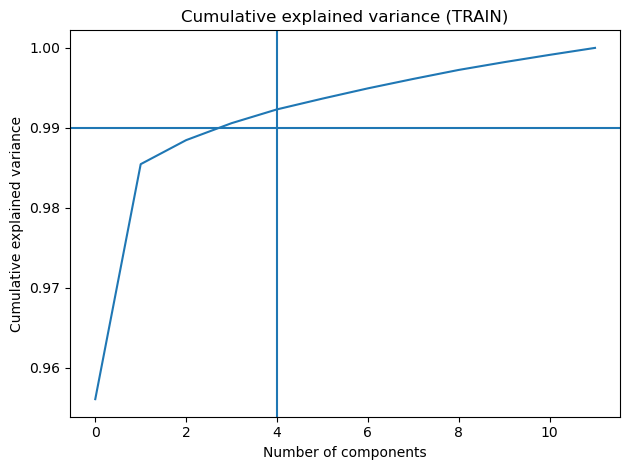

In [5]:
# Choose k by explained variance threshold
var_threshold = 0.99

# Fit PCA on TRAIN scaled data with full components first
pca_full = PCA(n_components=None, random_state=42)
pca_full.fit(X_train_s)

cum_var = np.cumsum(pca_full.explained_variance_ratio_)
k = int(np.searchsorted(cum_var, var_threshold) + 1)

print("Explained variance threshold:", var_threshold)
print("Selected k =", k, "out of", X_train_s.shape[1])

# Plot cumulative explained variance
plt.figure()
plt.title("Cumulative explained variance (TRAIN)")
plt.plot(cum_var)
plt.axhline(var_threshold)
plt.axvline(k)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.tight_layout()
plt.show()


After examining the correlation matrix, we observed substantial multicollinearity among many input attributes. To improve computational efficiency and reduce the risk of overfitting, we applied Principal Component Analysis (PCA) within the training pipeline, retaining 4 principal components that preserve approximately 99% of the total variance. This transformation yields an orthogonal (uncorrelated) feature space, which can improve numerical conditioning and model stability, and it is particularly beneficial for distance-based methods (e.g., KNN) by alleviating the curse of dimensionality.